# OPTIMIZACION

In [1]:

!pip install PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#import pandas_ta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#no comentar la siguiente linea si se usa google colab

#from google.colab import drive
#drive.mount('/content/drive')

#directorio donde estan guardados los datos
#direccion = os.path.join(os.getcwd(), "drive", "MyDrive", "Proyecto Integrador")
#os.chdir(direccion)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Se cargan los datos
direccion = os.path.join(os.getcwd(), "refined")
df = pd.read_csv(os.path.join(direccion,"BSE30_prediction.csv"), index_col="Date")


In [5]:
#Se calculan los rendimientos  acumulados de cada activo
daily_returns = df.pct_change()
cumulative_returns = (daily_returns +1).cumprod() -1
cumulative_returns.tail()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BHARTIARTL,COALINDIA,DRREDDY,HDFC,HDFCBANK,HEROMOTOCO,HINDUNILVR,ICICIBANK,INDUSINDBK,INFY,ITC,KOTAKBANK,LT,M&M,MARUTI,ONGC,POWERGRID,RELIANCE,SBIN,SUNPHARMA,TATAMOTORS,TATAMTRDVR,TATASTEEL,TCS,WIPRO,YESBANK
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-27,1.085766,0.243361,0.062623,0.172707,0.146717,0.144683,-0.280881,0.577379,0.698369,0.333228,0.775205,0.424113,0.740191,0.007276,0.268809,0.614037,0.618047,0.278707,1.328787,0.414312,0.463160,0.997367,0.384720,-0.347596,-0.133062,-0.294775,0.991833,0.340763,0.076797,0.813339
2018-04-30,1.098975,0.248128,0.063050,0.177110,0.150069,0.143696,-0.280918,0.581406,0.700327,0.333848,0.786056,0.424360,0.745745,0.011868,0.274423,0.623988,0.624741,0.289694,1.322440,0.413955,0.466677,1.001256,0.385749,-0.345373,-0.132504,-0.294709,0.991797,0.353843,0.072984,0.841073
2018-05-02,1.106118,0.255178,0.064811,0.181844,0.152446,0.141278,-0.280865,0.587688,0.704878,0.331198,0.789762,0.419977,0.746921,0.015711,0.282653,0.640900,0.630748,0.297333,1.314631,0.412864,0.467414,1.007263,0.382667,-0.345420,-0.133356,-0.295914,0.983577,0.363571,0.068123,0.859859
2018-05-03,1.110279,0.259314,0.068653,0.186326,0.153234,0.137507,-0.280457,0.594508,0.708551,0.328646,0.790438,0.419083,0.749231,0.017338,0.288166,0.651526,0.632819,0.304115,1.307903,0.412882,0.469408,1.009783,0.380782,-0.342466,-0.134915,-0.297611,0.980802,0.371310,0.061362,0.876121
2018-05-04,1.121603,0.261300,0.068904,0.186091,0.151125,0.131350,-0.280786,0.599318,0.714001,0.326533,0.792593,0.418989,0.752298,0.017787,0.289061,0.660500,0.633140,0.308319,1.299528,0.412509,0.472234,1.009698,0.379237,-0.342370,-0.136023,-0.299165,0.976561,0.377989,0.055447,0.884305


In [6]:
# Se identifican los 5 activos con los máximos rendimientos acumulados
top5 = cumulative_returns.tail(1)
top5 = pd.Series(index=top5.columns, data=top5.values[0] ).sort_values(ascending=False).head()
top5

MARUTI        1.299528
ADANIPORTS    1.121603
RELIANCE      1.009698
TATASTEEL     0.976561
YESBANK       0.884305
dtype: float64

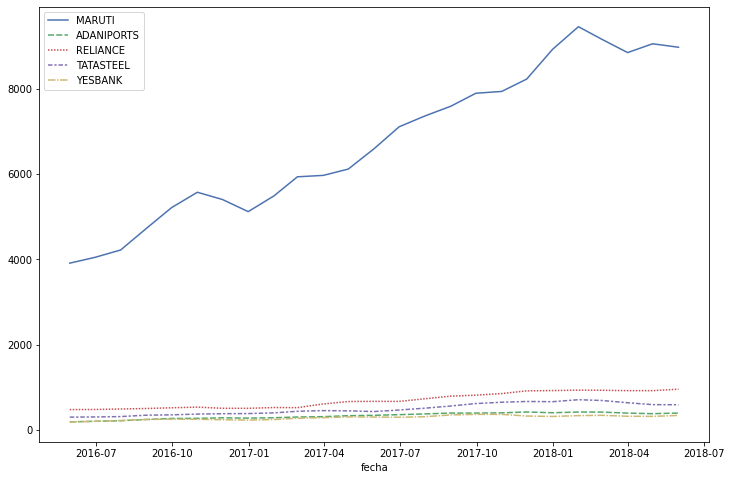

In [7]:
# se grafican los close price del top5 
df["fecha"] = pd.to_datetime(df.index)
plt.figure(figsize=(12,8))
#sns.lineplot(data=df.resample('M', on='fecha').sum()[top5.index])
#df.resample(rule="M").sum()
sns.lineplot(data=df.resample('M', on='fecha').mean()[top5.index])
#df.resample('M', on='fecha').avg()[top5.index]


In [8]:
df_port = df[top5.index]
# se asignan los pesos al portafolio
pesos = np.array([0.2,0.2,0.2,0.2, 0.2])
returns = df[top5.index].pct_change()

#matriz de covarianza
cov_anual = returns.cov()*252
cov_anual

,MARUTI,ADANIPORTS,RELIANCE,TATASTEEL,YESBANK
MARUTI,0.003200,0.001636,0.000391,0.001395,0.001170
ADANIPORTS,0.001636,0.004875,0.000976,0.002161,0.002575
RELIANCE,0.000391,0.000976,0.003524,0.000772,0.000897
TATASTEEL,0.001395,0.002161,0.000772,0.005142,0.002125
YESBANK,0.001170,0.002575,0.000897,0.002125,0.006539


In [9]:
port_var = np.dot(pesos.T,np.dot(cov_anual,pesos))
port_volatility = np.sqrt(port_var)
rendimiento_anual = np.sum(returns.mean()*pesos)*252


In [10]:
pct_var = str(round(port_var,2)*100)+'%'
pct_vola = str(round(port_volatility,2)*100)+'%'
pct_ret = str(round(rendimiento_anual,2)*100)+'%'

print('Rendimiento anual esperado: ' + pct_ret)
print('Annual volatilidad/riesgo: '+pct_vola)
print('Varianza anual: '+pct_var)

Rendimiento anual esperado: 38.0%
Annual volatilidad/riesgo: 5.0%
Varianza anual: 0.0%


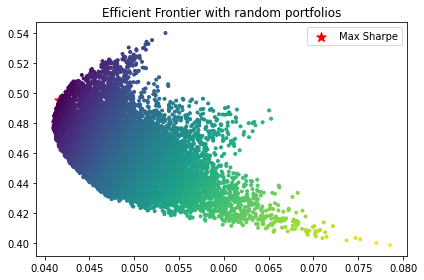

OrderedDict([('MARUTI', 0.47632), ('ADANIPORTS', 0.08266), ('RELIANCE', 0.34025), ('TATASTEEL', 0.0729), ('YESBANK', 0.02786)])
Expected annual return: 49.5%
Annual volatility: 4.2%
Sharpe Ratio: 11.42
Discrete allocation:  {'MARUTI': 3, 'ADANIPORTS': 10, 'RELIANCE': 16, 'TATASTEEL': 5, 'YESBANK': 3}
Funds remaining: $17.29


In [11]:

fig, ax = plt.subplots()

# Find the tangency portfolio
mu = expected_returns.mean_historical_return(df_port)
#S = risk_models.sample_cov(df)
#mu = expected_returns.capm_return(df)
S = risk_models.CovarianceShrinkage(df_port).ledoit_wolf()
ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
#plotting.plot_efficient_frontier(ef)
weights=ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

#ef = EfficientFrontier(mu,S,weight_bounds=(0,1))
#weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

# Distribucion en la compra de activos
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df_port)
#weights = cleaned_weights
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value = 50000)

allocation,leftover = da.lp_portfolio()
print('Discrete allocation: ',allocation)
print('Funds remaining: ${:.2f}'.format(leftover))




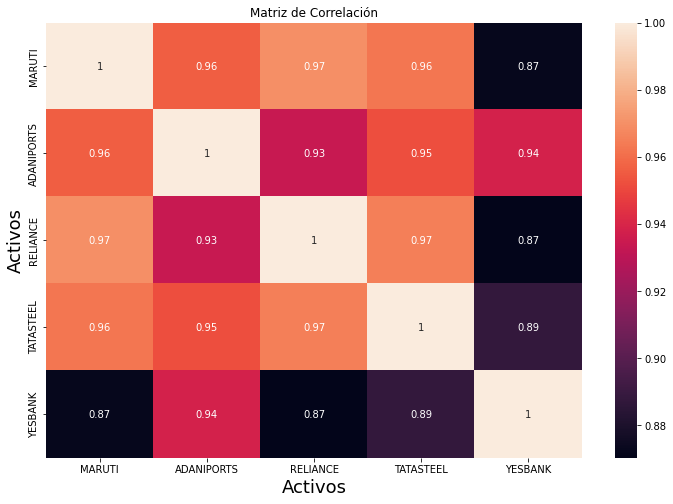

In [12]:
#Matriz de correlacion
correlation_mat = df_port.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_mat, annot = True)
plt.title('Matriz de Correlación')
plt.xlabel('Activos',fontsize=18)
plt.ylabel('Activos',fontsize=18)
plt.show()

### RECOMENDACIÓN


In [22]:
cor_mat = df.corr()

In [23]:
def portfolio_summary(activos):
  data = df[activos]

  fig, ax = plt.subplots()

  # Find the tangency portfolio
  mu = expected_returns.mean_historical_return(data)
  #S = risk_models.sample_cov(df)
  #mu = expected_returns.capm_return(df)
  S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
  ef = EfficientFrontier(mu,S,weight_bounds=(None,None))
  #plotting.plot_efficient_frontier(ef)
  weights=ef.max_sharpe()
  ret_tangent, std_tangent, _ = ef.portfolio_performance()
  ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

  # Generate random portfolios
  n_samples = 10000
  w = np.random.dirichlet(np.ones(len(mu)), n_samples)
  rets = w.dot(mu)
  stds = np.sqrt(np.diag(w @ S @ w.T))
  sharpes = rets / stds
  ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

  # Output
  ax.set_title("Efficient Frontier with random portfolios")
  ax.legend()
  plt.tight_layout()
  plt.savefig("ef_scatter.png", dpi=200)
  plt.show()

  #ef = EfficientFrontier(mu,S,weight_bounds=(0,1))
  #weights = ef.max_sharpe()
  cleaned_weights = ef.clean_weights()
  print(cleaned_weights)
  ef.portfolio_performance(verbose=True)

  # Distribucion en la compra de activos
  from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

  latest_prices = get_latest_prices(data)
  #weights = cleaned_weights
  da = DiscreteAllocation(weights,latest_prices,total_portfolio_value = int(moni))

  allocation,leftover = da.lp_portfolio()
  print('Discrete allocation: ',allocation)
  print('Funds remaining: ${:.2f}'.format(leftover))


In [71]:
print("Listado de activos: ")
print(*list(df.columns[:-1]), sep="\n")

Listado de activos: 
ADANIPORTS
ASIANPAINT
AXISBANK
BAJAJ-AUTO
BHARTIARTL
COALINDIA
DRREDDY
HDFC
HDFCBANK
HEROMOTOCO
HINDUNILVR
ICICIBANK
INDUSINDBK
INFY
ITC
KOTAKBANK
LT
M&M
MARUTI
ONGC
POWERGRID
RELIANCE
SBIN
SUNPHARMA
TATAMOTORS
TATAMTRDVR
TATASTEEL
TCS
WIPRO
YESBANK


¿Desea utilizar el portafolio por defecto como su portafolio de elección? (si/no)no
¿Cuánto dinero (USD) desea invertir? 100000
Por favor, indique el número de activos que desea en su portafolio: 5
¿Tiene activos agregados a su portafolio actual? (si/no)si
Escriba los activos que tiene en su portafolioADANIPORTS, MARUTI


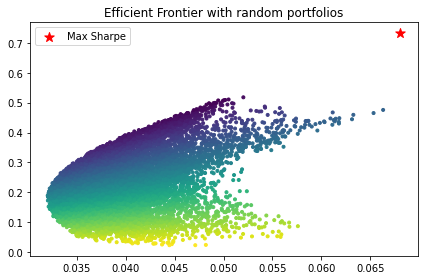

OrderedDict([('ADANIPORTS', 0.42957), ('MARUTI', 0.98579), ('COALINDIA', -0.0678), ('AXISBANK', -0.36468), ('INFY', 0.01711)])
Expected annual return: 73.3%
Annual volatility: 6.8%
Sharpe Ratio: 10.48
Discrete allocation:  {'ADANIPORTS': 72, 'MARUTI': 8, 'COALINDIA': -23, 'AXISBANK': -70}
Funds remaining: $276.67


In [69]:
default = input("¿Desea utilizar el portafolio por defecto como su portafolio de elección? (si/no)")

if default.lower() == "si":
  moni = input("¿Cuánto dinero (USD) desea invertir? ")
  portfolio_summary(top5.index.to_list())

elif default.lower() == "no":
  moni = input("¿Cuánto dinero (USD) desea invertir? ")
  n_activos = input("Por favor, indique el número de activos que desea en su portafolio: ")
  tiene_activos = input("¿Tiene activos agregados a su portafolio actual? (si/no)")

  if tiene_activos.lower() == "no":
    act_add = np.mean(cor_mat,1).sort_values()
    act_add = (1- np.abs(act_add) ).sort_values().tail(int(n_activos))
    new_activos = act_add.index.to_list()
    df_new_activos = df[new_activos]
    portfolio_summary(new_activos)

  elif tiene_activos.lower() == "si":
    activos_tiene = input("Escriba los activos que tiene en su portafolio (separados por una coma)")
    activos_tiene = activos_tiene.split(",")
    activos_tiene = [x.strip()  for x in activos_tiene]
    act_add = np.mean(cor_mat[activos_tiene],1).sort_values()
    act_add = (1- np.abs(act_add) ).sort_values().tail(int(n_activos)- len (activos_tiene))
    new_activos = activos_tiene + act_add.index.to_list()
    df_new_activos = df[new_activos]
    portfolio_summary(new_activos)


